## Costs



### Preface



There are a few modules you may need to install:



In [1]:
!pip install CFEDemands --upgrade
!pip install xarray
!pip install dvc[gdrive]
!pip install h5netcdf

  Using cached CFEDemands-0.2.9-py2.py3-none-any.whl (36 kB)
  Using cached dvc-2.0.18-py2.py3-none-any.whl (633 kB)
  Using cached rich-10.1.0-py3-none-any.whl (201 kB)
  Using cached shortuuid-1.0.1-py3-none-any.whl (7.5 kB)
  Using cached zc.lockfile-2.0-py2.py3-none-any.whl (9.7 kB)
  Using cached tabulate-0.8.9-py3-none-any.whl (25 kB)
  Using cached voluptuous-0.12.1-py3-none-any.whl (29 kB)
  Using cached dictdiffer-0.8.1-py2.py3-none-any.whl (16 kB)
  Using cached GitPython-3.1.14-py3-none-any.whl (159 kB)
Processing /home/jovyan/.cache/pip/wheels/0f/1b/ca/6263a5227f886599039aee3eed13951a6d44a02ee989ed6eb6/dpath-2.0.1-py3-none-any.whl
  Using cached dulwich-0.20.21-cp38-cp38-manylinux2010_x86_64.whl (516 kB)
  Using cached grandalf-0.6-py3-none-any.whl (31 kB)
  Using cached python_benedict-0.23.2-py3-none-any.whl (39 kB)
  Using cached diskcache-5.2.1-py3-none-any.whl (44 kB)
  Using cached fsspec-0.9.0-py3-none-any.whl (107 kB)
  Using cached funcy-1.15-py2.py3-none-any.whl (

All the data required for estimation and calculation can be found
   in a google spreadsheet.  Choose one to explore!



In [2]:
COUNTRY = 'Uganda'

In [3]:
URL = {'Uganda':'https://docs.google.com/spreadsheets/d/1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ/',
       'Tanzania':'https://docs.google.com/spreadsheets/d/1Tknc2F8K6SaA7j0R7J_NE8yJBTsCPPw77_Bfc04MY40/',
       'ICRISAT':'https://docs.google.com/spreadsheets/d/13Ig5hZif-NSHtgkKRp_cEgKXk0lOsdUB2BAD6O_FnRo'}
DAYS_PER_PERIOD = {'Uganda':7,'Tanzania':7,'ICRISAT':365.25} # Number of days of expenditure recall

To read the various sheets, we&rsquo;ll need some credentials.  Import a
 function to read google sheets, and point to an
 unencrypted json file that has the appropriate permissions:



In [4]:
from eep153_tools import read_sheets

!pip install oauth2client
!gpg --batch --passphrase "INPUT CLASS PASSPHRASE HERE" -d ../students.json.gpg > ../students.json

my_creds = 'students.json.gpg'

### Estimation



First, we pull in data and estimate CFE demands *given* the prices
    and budgets of households in the data.



In [5]:
import cfe
import numpy as np
from eep153_tools import read_sheets

x = read_sheets(URL[COUNTRY],json_creds=my_creds,sheet='Expenditures').set_index(['j','t','m'])
x.columns.name = 'i'
x = x.replace(0,np.nan)
y = np.log(x)

z = read_sheets(URL[COUNTRY],json_creds=my_creds,sheet='HH Characteristics').set_index(['j','t','m'])
z.columns.name = 'k'

p = read_sheets(URL[COUNTRY],json_creds=my_creds,sheet='Prices').set_index(['t','m'])
p.columns.name = 'i'

r = cfe.Result(y=y,z=z,prices=p)

r.get_alpha()
xhat = r.get_predicted_expenditures()

/opt/conda/lib/python3.8/site-packages/xarray/core/nputils.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


Estimation is kind of expensive, so you might want to save these
 results to use in your later code.



In [6]:
r.to_dataset("my %s.ds" % COUNTRY)

/opt/conda/lib/python3.8/site-packages/h5netcdf/core.py:769: FutureWarning: String decoding changed with h5py >= 3.0. See https://docs.h5py.org/en/latest/strings.html for more details. Currently backwards compatibility with h5py < 3.0 is kept by decoding vlen strings per default. This will change in future versions for consistency with h5py >= 3.0. To silence this warning set kwarg ``decode_vlen_strings=False``. Setting ``decode_vlen_strings=True`` forces vlen string decoding.
  warnings.warn(msg, FutureWarning, stacklevel=0)


<xarray.Dataset>
Dimensions:           (i: 51, j: 10159, k: 15, kp: 15, m: 1, t: 6)
Coordinates:
  * j                 (j) object '1013000201' '1013000202' ... 'H4301001'
  * i                 (i) object 'Beans' 'Beef' ... 'Water' 'Wheat (flour)'
  * k                 (k) object 'F 00-03' 'M 00-03' ... 'M 51+' 'log HSize'
  * t                 (t) object '2005-06' '2009-10' ... '2013-14' '2015-16'
  * m                 (m) object 'Uganda'
  * kp                (kp) <U9 'F 00-03' 'F 04-08' ... 'M 51+' 'log HSize'
Data variables:
    alpha             (i) float64 6.538 7.501 8.361 6.426 ... 5.816 nan nan
    beta              (i) float64 0.2344 0.3721 0.5759 0.6146 ... 0.462 nan nan
    delta             (k, i) float64 -0.018 -0.02526 -0.01543 ... nan nan
    prices            (i, t, m) float64 600.0 1.25e+03 ... 2.5e+03 2.7e+03
    characteristics   (k, j, t, m) float64 0.0 0.0 0.0 0.0 ... nan nan nan 1.946
    loglambdas        (j, t, m) float64 -1.233 0.01116 -0.6326 ... nan -0.4518
    a                 (i, t, m) float64 6.538 7.082 7.292 7.389 ... nan nan nan
    yhat              (j, t, m, i) float64 6.88 8.041 9.117 ... 7.259 nan nan
    ce                (j, t, m, i) float64 nan 1.118 -0.6234 ... -0.8352 nan nan
    cehat             (j, t, m, i) float64 0.2891 0.4588 0.7102 ... nan nan
    e                 (i, j, m, t) float64 nan nan nan nan ... nan nan nan nan
    delta_covariance  (i, k, kp) float64 0.0001698 2.553e-05 ... nan nan
    beta_covariance   object None
    se_delta          (i, k) float64 0.01303 0.01329 0.01108 ... nan nan nan
    se_beta           object None
    se_alpha          (i) float64 0.01585 0.01851 0.07667 ... 0.01593 0.0 0.0
    se_a              (i, t, m) float64 0.01585 0.01713 0.0173 ... nan nan nan
    y                 (i, j, m, t) float64 nan nan nan nan ... nan nan nan nan
    logp              (i, t, m) float64 6.397 7.131 7.313 ... nan 7.824 7.901
    z                 (k, j, t, m) float64 0.0 0.0 0.0 0.0 ... nan nan nan 1.946

By the same token, if you&rsquo;ve **already** saved the estimated result, you
 can skip estimation and just  load it&#x2026;



In [7]:
import cfe
r = cfe.from_dataset("my %s.ds" % COUNTRY)

In [41]:
r.get_alpha(as_df=True)

i
Beans             6.537682
Beef              7.500638
Beer              8.360626
Bun               6.425699
Cabbages          5.882989
Cassava           6.592677
Chicken           8.063880
Cigarettes        6.813737
Coffee            4.628108
Cooking oil       5.962613
Dodo              5.574761
Dried fish        6.520910
Eggs              6.182399
Fresh fish        7.015686
Fresh milk        6.832323
Goat meat         7.277119
Ground nut        6.229871
Irish potato      6.807111
Maize             6.619745
Mangos            6.009520
Matoke            7.386895
Millet            6.335612
Onions            4.994139
Oranges           5.658361
Other Alcohol     6.883310
Other Fruit       6.053041
Other Tobacco     5.445785
Other Veg.        5.579663
Other foods       6.864447
Passion fruit     6.241966
Peas              6.197789
Pork              7.083545
Restaurant        8.074264
Rice              6.708283
Salt              4.233558
Sim sim           6.166700
Soda              7.077052

In [42]:
r.get_beta(as_df=True).dropna()

i
Beans             0.234401
Beef              0.372068
Beer              0.575916
Bun               0.614612
Cabbages          0.302597
Cassava           0.100006
Chicken           0.324125
Cigarettes        0.533225
Coffee            0.655771
Cooking oil       0.454043
Dodo              0.337421
Dried fish        0.337026
Eggs              0.454384
Fresh fish        0.387190
Fresh milk        0.570633
Goat meat         0.377250
Ground nut        0.310636
Irish potato      0.320683
Maize             0.248386
Mangos            0.396619
Matoke            0.438673
Millet            0.195983
Onions            0.423031
Oranges           0.560503
Other Alcohol     0.424832
Other Fruit       0.575993
Other Tobacco     0.497631
Other Veg.        0.439217
Other foods       0.709945
Passion fruit     0.689185
Peas              0.353778
Pork              0.352783
Restaurant        0.566696
Rice              0.391052
Salt              0.108925
Sim sim           0.206310
Soda              0.512992

In [43]:
r.delta.to_dataframe().unstack('k').dropna()

delta                                                    \
k                F 00-03   F 04-08   F 09-13   F 14-18   F 19-30   F 31-50   
i                                                                            
Beans          -0.017999  0.034981  0.052855  0.063154  0.023157  0.052992   
Beef           -0.025260  0.019889  0.035193  0.044315  0.111598  0.081288   
Beer           -0.015431 -0.036532  0.018052  0.074591  0.131731  0.046029   
Bun            -0.087353 -0.006391  0.040575  0.091875  0.160765  0.083337   
Cabbages       -0.003930 -0.009994  0.037094  0.063125  0.049393  0.027506   
Cassava         0.004183  0.065387  0.056505  0.078548 -0.045982  0.002342   
Chicken        -0.039953  0.015808  0.022267  0.014636  0.104601  0.057266   
Cigarettes     -0.025908  0.015616  0.083046  0.116204  0.160765  0.088711   
Coffee         -0.027479  0.086817  0.002732  0.109072  0.166417  0.178985   
Cooking oil    -0.052017 -0.025481  0.012932  0.077885  0.138742  0.018563   
Dodo           -0.002092  0.009070  0.054516  0.009381  0.060706  0.111837   
Dried fish     -0.007132  0.021437  0.034846  0.036524  0.125292  0.057210   
Eggs           -0.111515 -0.005256  0.014971  0.029990  0.113263  0.003769   
Fresh fish     -0.005652 -0.004744  0.042384  0.071407  0.086152  0.047757   
Fresh milk      0.038668 -0.040441 -0.009191  0.043499  0.124750  0.055483   
Goat meat      -0.009948  0.057223  0.023939  0.048050  0.086131  0.083003   
Ground nut     -0.015400  0.032595  0.053178  0.076803  0.092084  0.138688   
Irish potato   -0.028844  0.026367  0.104731  0.055365 -0.020372  0.049677   
Maize           0.048070  0.090715  0.116153  0.066806  0.003468  0.038234   
Mangos         -0.002556 -0.020819 -0.022345  0.014498 -0.038583 -0.047458   
Matoke         -0.028418  0.016977  0.025365  0.061394  0.094764  0.064267   
Millet          0.003166  0.008477  0.031641  0.040993 -0.021391  0.010887   
Onions         -0.073857 -0.036582  0.008960  0.057534  0.152761  0.071199   
Oranges        -0.044841  0.043257 -0.007226  0.118968  0.168256  0.036286   
Other Alcohol  -0.093747 -0.013331 -0.020351  0.070077  0.117530  0.070451   
Other Fruit    -0.008104  0.022932  0.027286  0.023663  0.096108  0.064138   
Other Tobacco  -0.079231  0.012811  0.046680  0.099380  0.182294 -0.016814   
Other Veg.     -0.014914  0.011129  0.017122  0.033280  0.074101  0.114974   
Other foods     0.012370 -0.008227  0.029583  0.058048  0.223057  0.256621   
Passion fruit  -0.032325 -0.038923 -0.028887  0.062640  0.150987  0.198311   
Peas           -0.026376 -0.023970  0.016232  0.045119  0.028415  0.044640   
Pork           -0.053361  0.007876  0.032283  0.043560  0.095754  0.097909   
Restaurant     -0.136361 -0.038271  0.038828  0.068996  0.228282  0.109589   
Rice           -0.008266  0.048031  0.051108  0.068813  0.090732  0.017859   
Salt            0.010307  0.020341  0.033765  0.039208  0.016516  0.027499   
Sim sim        -0.006530 -0.011156  0.006429  0.056201  0.031903  0.007107   
Soda           -0.049268 -0.055025  0.073619  0.079079  0.150167  0.011735   
Sorghum        -0.105442 -0.072370 -0.004487 -0.036668 -0.070149 -0.027391   
Sugar          -0.026405  0.008981  0.034377  0.067575  0.133521  0.097303   
Sweet Banana   -0.031568 -0.039908 -0.006773  0.070470  0.079022  0.090499   
Sweet Potatoes  0.016238  0.098942  0.085182  0.075454  0.001702  0.049116   
Tea            -0.022437  0.019902  0.026469  0.064690  0.123288  0.129120   
Tomatoes       -0.037621 -0.012002  0.020229  0.060092  0.166797  0.073032   

                                                                            \
k                  F 51+   M 00-03   M 04-08   M 09-13   M 14-18   M 19-30   
i                                                                            
Beans           0.082714 -0.019997  0.025129  0.067315  0.071476  0.066831   
Beef            0.049441 -0.019040  0.017515  0.047792  0.052201  0.102283   
Beer           -0.083552 -0.037448 -0.05

The triple of paramters  (𝛼,𝛽,𝛿)  completely describes the demand system and the corresponding utility function (over the goods we observe).

### Ceteris Paribus 

holding other things equal



We begin by setting up some benchmarks for prices and budgets, so
    the things we don&rsquo;t want to change we can hold fixed.



In [8]:
### First year, first market, and some good.  Change if you wish! ###
my_t = r.coords['t'].data.flatten()[0]
my_m = r.coords['m'].data.flatten()[0]
my_i = r.coords['i'].data.flatten()[0]
#####################################################################

p = r.prices.sel(t=my_t,m=my_m,drop=True)
# phat = refernce prices for each good
phat = p.to_dataframe('i').dropna().squeeze()

ref_price = r.prices.sel(i=my_i,t=my_t,m=my_m)
P = np.linspace(ref_price/10,ref_price*5,50)

def my_prices(p0,p=phat,i=my_i):
    """
    Set price of good i to p0, holding remaining prices fixed at values in p.
    """
    p = p.copy()
    p.loc[i] = p0
    return p.squeeze()

In [11]:
my_t, my_m, my_i

('2005-06', 'Uganda', 'Beans')

In [14]:
phat

i
Beans                600.000000
Beef                2500.000000
Beer                2800.000000
Bun                 1200.000000
Butter, etc.        3200.000000
Cassava              150.000000
Cassava (flour)      333.333333
Chicken             3000.000000
Cigarettes          8000.000000
Coffee               800.000000
Cooking oil          454.545455
Dodo                 100.000000
Dried fish           700.000000
Fresh fish          1000.000000
Fresh milk           400.000000
Ghee                4000.000000
Goat meat           2500.000000
Ground nut          1200.000000
Infant formula      8000.000000
Irish potato         250.000000
Maize                600.000000
Mangos                66.666667
Matoke               250.000000
Millet               500.000000
Onions               800.000000
Oranges              250.000000
Other Alcohol        800.000000
Other Fruit          225.000000
Other Tobacco      20000.000000
Other Veg.           200.000000
Other drinks         333.333333
Other 

### Nutrient Demands



The nutrient value of food consumed by the household is just the
   product of its diet and a food conversion table.  So let&rsquo;s write a
   function that describes that product:



In [15]:
# Get FCT:
fct = read_sheets(URL[COUNTRY],
                  json_creds='../students.json',
                  sheet='FCT').set_index('i')
fct.columns.name='n'

def nutrient_demand(x,p):
    c = r.demands(x,p)
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    N = N.loc[~N.index.duplicated()]
    
    return N

In [16]:
fct

n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
i,,,,,,,,,,,,,,,
Beans,1060,65,50,1040,270,191,16.0,2.86,0.49,0.87,0,0.0,0.73,14,7.0
Beef,2910,264,0,50,90,0,27.0,33.50,2.20,0.50,0,18.5,1.70,0,60.0
Beer,430,5,0,60,40,35,0.0,5.10,0.30,0.10,0,0.2,0.50,0,0.0
Bread,2660,76,20,1110,1510,506,37.0,43.85,3.31,4.55,0,0.0,0.84,0,7.0
Bun,2660,76,20,1110,1510,506,37.0,43.85,3.31,4.55,0,0.0,0.84,0,7.0
Cabbages,250,13,30,430,400,58,5.0,2.34,0.40,0.61,50,0.0,1.24,366,2.0
Cassava,1600,14,20,270,160,381,3.0,8.54,0.48,0.87,10,0.0,0.88,206,3.0
Cassava (flour),3140,26,40,360,310,766,19.0,14.00,0.50,3.10,70,0.0,7.00,720,7.0
Chapati,2750,91,20,240,860,557,14.0,21.42,0.97,2.67,0,0.0,0.34,0,8.0


### Nutritional requirements



Individuals have nutritional requirements established by nutrition
 scientists.  Here we grab one such set of requirements:



In [18]:
# rdi = recommended daily intake
rdi = read_sheets(URL[COUNTRY],
                  json_creds='../students.json',
                  sheet='RDI').set_index('n').replace(np.nan,0)
rdi.columns.name = 'k'

rdi = rdi.replace('',0)
rdi

k,M 00-03,F 04-08,M 04-08,F 09-13,M 09-13,F 14-18,M 14-18,F 19-30,M 19-30,F 31-50,M 31-50,F 51+,M 51+
n,,,,,,,,,,,,,
Energy,1000.0,1200.0,1400.0,1600.0,1800.0,1800.0,2200.0,2000.0,2400.0,1800.0,2200.0,1600.0,2000.0
Protein,13.0,19.0,19.0,34.0,34.0,46.0,52.0,46.0,56.0,46.0,56.0,46.0,56.0
Fiber,14.0,16.8,19.6,22.4,25.2,25.2,30.8,28.0,33.6,25.2,30.8,22.4,28.0
Folate,150.0,200.0,200.0,300.0,300.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0
Calcium,700.0,1000.0,1000.0,1300.0,1300.0,1300.0,1300.0,1000.0,1000.0,1000.0,1000.0,1200.0,1000.0
Carbohydrate,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0,130.0
Iron,7.0,10.0,10.0,8.0,8.0,15.0,11.0,18.0,8.0,18.0,8.0,8.0,8.0
Magnesium,80.0,130.0,130.0,240.0,240.0,360.0,410.0,310.0,400.0,320.0,420.0,320.0,420.0
Niacin,6.0,8.0,8.0,12.0,12.0,14.0,16.0,14.0,16.0,14.0,16.0,14.0,16.0


#### Nutritional Needs of Households



Our data on demand and nutrients is at the *household* level; we
    can&rsquo;t directly compare household level nutrition with individual
    level requirements.  What we **can** do is add up minimum individual
    requirements, and see whether household total exceed these.  This
    isn&rsquo;t a guarantee that all individuals have adequate nutrition
    (since the way food is allocated in the household might be quite
    unequal, or unrelated to individual requirements), but it is
    *necessary* if all individuals are to have adequate nutrition.

For the average household, the number of different kinds of people
can be computed by averaging over households:



In [20]:
# Find average household characteristics for reference period & place
zbar = r.z.sel(t=my_t,m=my_m,drop=True).mean('j').to_dataframe()
zbar

,z
k,
F 00-03,0.371236
M 00-03,0.372197
F 04-08,0.434017
M 04-08,0.427611
F 09-13,0.407431
M 09-13,0.411595
F 14-18,0.339526
M 14-18,0.344331
F 19-30,0.568546


Now, the inner/dot/matrix product between `zbar` and the `rda`
 DataFrame of requirements will give us minimum requirements for the
 average household:



In [21]:
# This matrix product gives minimum nutrient requirements for average
# household in reference year & place
my_rdi,my_zbar = rdi.align(zbar.T,axis=1,join='inner')
hh_rdi = my_rdi@my_zbar.T

# But this is per *day*, while our data is per period (month for Uganda):
hh_rdi = hh_rdi*DAYS_PER_PERIOD[COUNTRY]
hh_rdi

,z
n,
Energy,61649.775785
Protein,1366.551570
Fiber,863.096861
Folate,11449.775785
Calcium,37338.565022
Carbohydrate,4511.233184
Iron,379.840807
Magnesium,9815.201794
Niacin,436.834081


#### Nutritional Adequacy of Food Demands



Since we can trace out demands for nutrients as a function of $(x,p)$,
 and we&rsquo;ve computed minimum nutritional requirements for the average
 household, we can *normalize* nutritional intake to check the adequacy
 of diet.



In [22]:
def nutrient_adequacy_ratio(x,p):
    return (nutrient_demand(x,p)/hh_rdi.T).squeeze()

Maybe select a few nutrients of particular interest&#x2026;



In [32]:
UseNutrients = ['Energy','Protein','Iron','Calcium']

### Simple Policy Experiments



Consider two policies:  First, changing income so that some proportion
 of the population achieves nutritional adequacy.  Here choose quantile
 we&rsquo;re interested in (e.g., a quantile of 0.5 is the median; a quantile
 of 0.25 is the household at the 25th percentage point of the distribution).



In [24]:
# A quantile of 0.5 is the median.  Play with quantile value, or just assign.
xbar = r.get_predicted_expenditures().sel(t=my_t,m=my_m).sum('i')

# Drop households with /no/ predicted expenditures
xbar = xbar.where(xbar>0)

# make it median household budget
x0 = xbar.quantile(0.5,'j') # Budget (median household)
#x0 = 50

# Range of budgets to explore
X = np.linspace(x0/10,x0*5,50)

/opt/conda/lib/python3.8/site-packages/xarray/core/nputils.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


### Compensated Policy Experiments



In [ ]:
# Marshallian = fixed budget -- trying to maximize utility subject to that

# Hicksian = fixed utility -- only involve substitution -- increase price --> also given a bit more income (to stay at same level of utility)

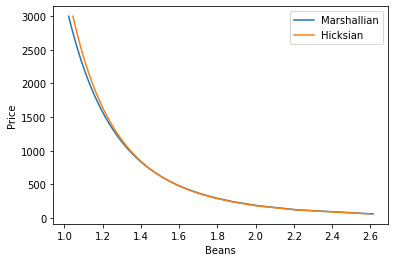

In [29]:
import matplotlib.pyplot as plt

#my_i = 'Milk'
my_i = 'Beans'
ref_price = r.prices.sel(i=my_i,t=my_t,m=my_m)
P = np.linspace(ref_price/10,ref_price*5,50)

U0 = r.indirect_utility(x0,p)

### If you're getting lots of not useful warnings you want to ignore
# import warnings
# warnings.filterwarnings('ignore',category=UserWarning)
####################################################################

plt.plot([r.demands(x0,my_prices(p0,i=my_i))[my_i] for p0 in P],P)
plt.plot([r.demands(U0,my_prices(p0,i=my_i),type="Hicksian")[my_i] for p0 in P],P)
plt.ylabel('Price')
plt.xlabel(my_i)
#plt.axhline(p.sel(i=my_i).values)
plt.legend(("Marshallian","Hicksian"))

In [30]:
# how much extra income i need in order to hold my utility constant at this higher price for the good
def compensating_variation(U0,p0,p1):
    x0 = r.expenditure(U0,p0)
    x1 = r.expenditure(U0,p1)

    return x1-x0

# if tax increases the price, how much extra revenue does the tax create?
def revenue(U0,p0,p1,type='Marshallian'):
    """(Un)Compensated revenue from taxes changing vector of prices from p0 to p1.

    Note that this is only for *demand* side (i.e., if supply perfectly elastic).
    """
    
    dp = p1 - p0 # Change in prices

    c = r.demands(U0,p1,type=type)

    dp,c = dp.align(c,join='inner')

    return dp.T@c


def deadweight_loss(U0,p0,p1):
    """
    Deadweight loss of tax/subsidy scheme creating wedge in prices from p0 to p1.

    Note that this is only for *demand* side (i.e., if supply perfectly elastic).
    """
    cv = compensating_variation(U0,p0,p1)

    return cv - revenue(U0,p0,p1,type='Hicksian') 
    
    
def compensated_nutrient_demand(U,p,z=None):
    c = r.demands(U,p,z=z,type='Hicksian')
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    return N

def compensated_nutrient_adequacy_ratio(U,p):
    return (compensated_nutrient_demand(U,p)/hh_rdi.T).squeeze()

Examine effects of price changes on *compensated* nutrient adequacy
(i.e., a price increase is accompanied by additional income to keep
utility constant).



Text(0.5, 0, 'Price of Matoke')

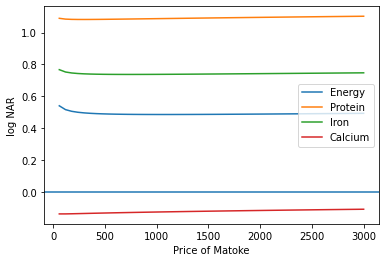

In [38]:
## if flat: as price increases, Nutrients intake doesn't change very much
my_i = 'Matoke'

fig,ax2 = plt.subplots()
ax2.set_ylabel('log NAR')
ax2.plot(P,[np.log(compensated_nutrient_adequacy_ratio(U0,my_prices(p0,i=my_i))[UseNutrients]) for p0 in P])
ax2.legend(UseNutrients)
ax2.axhline(0)
ax2.set_xlabel("Price of %s" % my_i)

Examine effects of price changes on revenue (if price change due to a
tax or subsidy) and compensating variation.



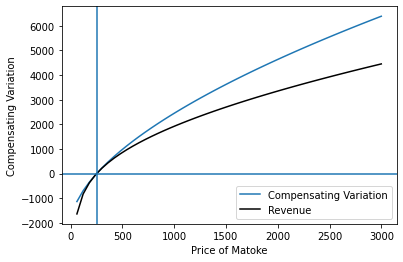

In [39]:
fig, ax1 = plt.subplots()

ax1.plot(P,[compensating_variation(U0,phat,my_prices(p0,i=my_i)) for p0 in P])
ax1.set_xlabel("Price of %s" % my_i)
ax1.set_ylabel("Compensating Variation")

ax1.plot(P,[revenue(U0,phat,my_prices(p0,i=my_i),type='Hicksian') for p0 in P],'k')
ax1.legend(('Compensating Variation','Revenue'))
ax1.axhline(0)
ax1.axvline(phat.loc[my_i])

Differences between revenue and compensating variation is deadweight-loss:



Text(0, 0.5, 'Deadweight Loss')

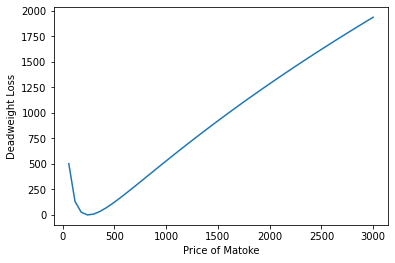

In [40]:
fig, ax1 = plt.subplots()

ax1.plot(P,[deadweight_loss(U0,phat,my_prices(p0,i=my_i)) for p0 in P])
ax1.set_xlabel("Price of %s" % my_i)
ax1.set_ylabel("Deadweight Loss")